# Quantum Simulation of the Heisenberg Model using Fast-Forwarded Trotterization on ibmq_jakarta

Refat Ismail, Nikolaos Angelinos and Debarghya Chakraborty

Category: Qiskit defaults


## 0 Abstract
Trotterization-based approaches to Quantum Simulation exhibit linear scaling of circuit depth with the number of trotterization steps, which limits their use on NISQ devices. Here we develop a new approach which dramatically reduces the number of two-qubit gates needed for large number of trotter steps. Our new approach, which we call Fast-Forwarded Trotterization, leverages established algorithms for efficient Unitary Synthesis to give a constant scaling of circuit depth with the number of trotter steps. This enables the construction of low-depth circuits for high number of trotter steps where the effects of trotter error is negligible. In addition, we employ Measurement Error Mitigation to deal with the fidelity loss coming from readout errors. Our runs give an average fidelity of $0.9912 \pm 0.001$ on the noisy simulator. Our error analysis shows that our result is within $0.004 $ of the maximum possible fidelity for the same problem.

## 1 Introduction

We develop a quantum circuit that evolves the initial $3$-qubit state $|110\rangle$, for time from $t=0$ to $t=\pi$, according to the Hamiltonian
\begin{equation}
H= X_{1} X_{2} + Y_1 Y_2 +Z_{1}Z_{2}  + X_{2} X_{3} + Y_2 Y_3 + Z_{2}Z_{3} 
\end{equation}
Indices (1,2,3) correspond to qubits 5, 3 and 1 on ibmq_jakarta. We approximate the time-evolution operator by a trotterized version $U(t)\approx U_{trott}(t,n)$ where $n$ is the number of Trotter steps.

## 2 Methods


### 2-1 Fast Forwarded Trotterization


On trotterizing a time-evolution operator, a trade-off arises between convergence to $U(t)$ and circuit depth, for large number of trotter steps. An additional challenge comes from the sub-optimal synthesis of three(or more)-qubit unitaries into native gates. Even using the current best Unitary Synthesis algorithms, this introduces further unnecessary gate-overhead that aggravates the circuit depth issue, making simulating $U(t)$ on NISQ devices particularly challenging. 

To address these two challenges, we implement our trotterization in a way that leverages the existence of optimal two-qubit unitary synthesis algorithms. In fact, two-qubit unitaries can always be synthesized using at most 3 CNOTs [1] .

We start by expressing our Hamiltonian as: 

$$ H =  Q^{†} \tilde{H} Q $$

where $\tilde{H}$ is a Hermitian operator acting on only two qubits, and Q is a 3-qubit unitary. This representation is possible because all eigenvalues of $ H $ have even multiplicity. Consequently, $U(t)$ would look like:

$$ U(t) = \exp{(-i t H)} = \exp{(-i t Q^{†} \tilde{H} Q)} = Q^{†} \exp{(-i t  \tilde{H} )}Q  $$ 

We make  the following choice of $\tilde{H}$ and $Q$ out of all possible candidates : 

$$\tilde{H} = Z_{1} + X_{1} + X_{3} + Z_{3} - X_{1} Z_{3} - Z_{1}X_{3}  $$ 

and,

$$ Q  = X_2 CNOT_{3,2}CNOT_{1,2}X_2 CNOT_{2,1}CNOT_{2,3} $$ 

This choice fits well with ibmq_jakarta connectivity constraints. Details on how we constructed it and alternative choices are presented in the appendix. Next, we trotterize the operator exponential as follows:

$$ U(t) \approx U_{trott}(t,1) =  Q^{†} \left(  \exp{(-i t Z_{1} )} \exp{(-i t Z_{3} )}\exp{(i t Z_{1} X_{3}  )} \exp{(-i t X_{1} )} \exp{(-i t X_{3} )} \exp{(i t X_{1} Z_{3})}  \right) Q $$ 

for small t. For longer times, we see that the Q unitaries factor out as follows:

$$ U(t) \approx U_{trott}(t,n) = Q^{†} \left[  \exp{(-\frac{i t}{n} Z_{1} )} \exp{(-\frac{i t}{n} Z_{3} )}\exp{(\frac{i t}{n}  Z_{1} X_{3} )} \exp{(-\frac{i t}{n}  X_{1}  )} \exp{(-\frac{i t}{n} X_{3} )} \exp{(\frac{i t}{n}X_{1} Z_{3})} \right]^n Q $$ 

Notice that as we increase trotter steps, only the operator in brackets changes. This operator is a two-qubit unitary, which can be optimally implemented, as mentioned before, using only 3 CNOTs, regardless of how many trotter steps we have. This fixed scaling of CNOTs with trotter steps is why we call this approach Fast-Forwarded Trotterization, in analogy with existing Fast-Forwarding methods [2], where circuit depth of $U(t)$ scales sub-linearly with time evolved. It's worth noting that this feature is also exhibited in our approach. We highlight this further in the results section.

In practice, we construct our trotterized circuit component by component and leave the job of optimally synthesizing two-qubit unitaries to Qiskit transpiler. We set the "optimization_level" option to 3, which effectively resynthesizes two-qubit blocks of gates in the circuit. Our resulting transpiled circuits have very low CNOT counts; as low as 2 CNOTs. We prefer this approach over importing Unitary Synthesis libraries because we believe it is more user-friendly.

### 2-2 Measurement Error Mitigation
Readout errors being another big part of device error, we choose to implement a standard mitigation technique: [Measurement Error Mitigation](https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html).

References:

[1] [Universal quantum circuit for two-qubit transformations with three controlled-NOT gates](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.010301)

[2] [Variational fast forwarding for quantum simulation beyond the coherence time](https://www.nature.com/articles/s41534-020-00302-0)

## 3 Code

### 3-1 Importing Libraries

In [1]:
import numpy as np
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

#for measurment error mitigation
import qiskit.ignis.mitigation.measurement as mc

#for symmetry verification
from copy import deepcopy

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_123/1950993755.py:12: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [9]:
pip install qiskit --upgrade

     |████████████████████████████████| 6.7 MB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 19.2 MB 2.2 kB/s  eta 0:00:01 0:00:01
  Created wheel for qiskit: filename=qiskit-0.38.0-py3-none-any.whl size=12147 sha256=c22e0744e3e21420f19aaf1ffe151d34167dfaee059d8917b1498718a516b496
  Stored in directory: /home/jovyan/.cache/pip/wheels/20/44/04/94a2ed16931adbd92d43edff72cc9a9ac8721227ecbacd84eb
Successfully built qiskit
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.21.1
    Uninstalling qiskit-terra-0.21.1:
      Successfully uninstalled qiskit-terra-0.21.1
  Attempting uninstall: qiskit-aer
    Found existing installation: qiskit-aer 0.10.4
    Uninstalling qiskit-aer-0.10.4:
      Successfully uninstalled qiskit-aer-0.10.4
  Attempting uninstall: qiskit
    Found existing installation: qiskit 0.37.1
    Uninstalling qiskit-0.37.1:
      Successfully uninstalled qiskit-0.37.1
Note: you may need to restart the kernel to use updated p

### 3-2 Quantum Devices

In [ ]:
#load IBMQ Account data

#IBMQ.save_account(TOKEN) 
provider = IBMQ.load_account()

In [3]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

### 3-3 Decomposition of $U(t)$ into Quantum Gates


Building the circuit components

In [4]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [5]:
# Build a subcircuit for X (t) two-qubit gate
X_qr = QuantumRegister(1)
X_qc = QuantumCircuit(X_qr, name='X')

X_qc.rx(2*t, 0) 
# Convert custom quantum circuit into a gate
X = X_qc.to_instruction()


# Build a subcircuit for  -ZX  (t) two-qubit gate
ZXminus_qr = QuantumRegister(2)
ZXminus_qc = QuantumCircuit(ZXminus_qr, name='-ZX')

ZXminus_qc.ry(-np.pi/2,1)
ZXminus_qc.cnot(0,1)
ZXminus_qc.rz(-2 * t, 1)
ZXminus_qc.cnot(0,1)
ZXminus_qc.ry(np.pi/2,1)

# Convert custom quantum circuit into a gate
ZXminus = ZXminus_qc.to_instruction()


# Build a subcircuit for Z(t) two-qubit gate
Z_qr = QuantumRegister(1)
Z_qc = QuantumCircuit(Z_qr, name='Z')

Z_qc.rz(2*t, 0) 
# Convert custom quantum circuit into a gate
Z = Z_qc.to_instruction()

Combining components to construct trotter gate
$$ \left(  \exp{(-\frac{i t}{n} Z_{1} )} \exp{(-\frac{i t}{n} Z_{3} )}\exp{(\frac{i t}{n}Z_{1} X_{3} )} \exp{(-\frac{i t}{n} X_{1} )} \exp{(-\frac{i t}{n} X_{3} )} \exp{(\frac{i t}{n} X_{1} Z_{3}   )} \right)$$ 

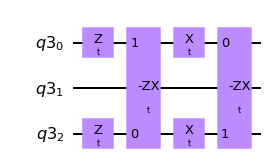

In [6]:
# Trotterization circuit
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

Trot_qc.append(Z, [Trot_qr[2]])
Trot_qc.append(Z, [Trot_qr[0]])
Trot_qc.append(ZXminus, [Trot_qr[2],Trot_qr[0]])
Trot_qc.append(X, [Trot_qr[2]])
Trot_qc.append(X, [Trot_qr[0]])
Trot_qc.append(ZXminus, [Trot_qr[0], Trot_qr[2]])
    
# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()
Trot_qc.draw()

Implementing Unitary 
$$ Q  = X_2 CNOT_{3,2}CNOT_{1,2}X_2 CNOT_{2,1}CNOT_{2,3}. $$ 

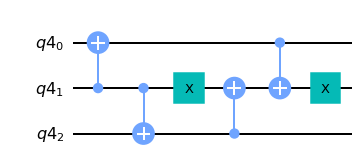

In [7]:
# Build a subcircuit for Q: H = Q^(dagger)(I \otimes Htilde) Q
Q_qr = QuantumRegister(3)
Q_qc = QuantumCircuit(Q_qr, name='Q')

Q_qc.cnot(1,0)
Q_qc.cnot(1,2) 
Q_qc.x(1)
Q_qc.cnot(2,1)
Q_qc.cnot(0,1)
Q_qc.x(1)

# Convert custom quantum circuit into a gate
Q = Q_qc.to_instruction()
Q_qc.draw()

### 3-5 Constructing our circuits

Time evolution circuit.

According to our analysis, discussed later, trotter error is effectively negligible for n>26 trotter steps. We  choose to implement n=31.

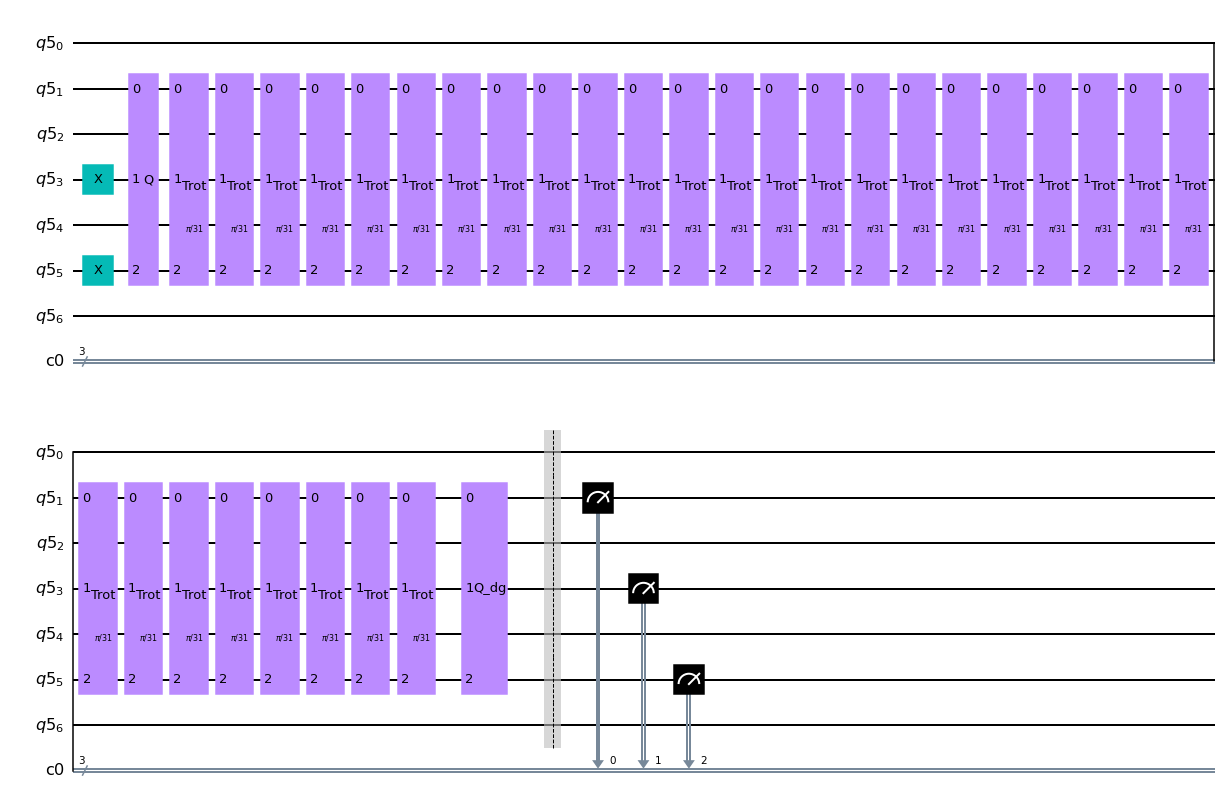

In [8]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 31 ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)


# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
qc.append(Q,[qr[1], qr[3], qr[5]]) #applying Q

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
qc.append(Q.inverse(),[qr[1], qr[3], qr[5]])  #applying Q^{dagger}

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps});

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]]);

st_qcs[-1].draw()
#st_qcs[-1].decompose().draw()

Measurement mitigation circuits

In [9]:
#construct measurment calibration circuits and labels
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[1,3,5]);

### 3-6 Execute
Executing on Jakarta and simulators

To tackle the randomness introduced during transpiling, as it depends on the generation of a random seed, we transpiled our (27) state tomography circuits and kept track of CNOT counts. We recorded the seeds which corresponded to the minimum number of CNOTs. We found a multitude of them and we randomly picked one.

In [10]:
reps = 8;
shots=8192;
optimization_level = 3 #Transpiler will optimize circuit including collapsing cnots, effectivelty fast forawrading trotterization
initial_layout =[0, 1, 2, 3, 4, 5, 6]; #Forcing transpiler to use Jakarta qubit in the given circuit order to satisfy competition requirments
seed_transpiler =6; # One of the seeds that minimize CNOT counts

#backend = sim
#backend = sim_noisy_jakarta
backend = jakarta

calibs_shots = 40000 # how many times to run meas calibs circuit

print('backend:', backend)

backend: ibmq_jakarta


Executing circuits

In [58]:
jobs = [];
jobs_id =[];
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend= backend, shots= shots, optimization_level = optimization_level, initial_layout = initial_layout, seed_transpiler= seed_transpiler);
    jobs_id.append(job.job_id());
    jobs.append(job);
 
 #Measurement error mitigation
job_cal = execute(meas_calibs, backend=backend, shots=calibs_shots);
cal_id = job_cal.job_id();

print('jobs ids:',jobs_id)
print('calibration circuits id:', cal_id)


jobs ids: ['2c42fea9-a7b6-4626-ad7a-83a3c022aab9', '6893f337-3034-4878-bf17-fad1c3491245', 'c877d614-ef39-48b3-a3a0-73ffbc9ccfd0', 'a3fddc72-a11a-479a-a2dd-804549b24e98', '4b6ba5fe-193b-47db-8ec3-1b4d235fe403', 'f4ea1946-fbc9-4a1a-96b8-086ada086f7e', 'd8fbb511-8327-4f7e-86bf-e7590f249dfe', '339e3b3b-a8ef-4729-8ca0-9189cf57ac1a']
calibration circuits id: dbb7f862-f249-49b2-9ef1-1b4583a799c6


### 3-7 Results Analysis
Extract the results for the completed jobs and compute the state tomography fidelity for each repetition. You may choose to include other post-processing analyses here as well.

One of our Jakarta ran jobs IDs. It was still in queue as of time of submission. Please remove the ''' quotation marks at the start and finish if you want to retrieve it.

In [23]:

#retrieve jobs from job IDs

job_ids = ['625b38c48e4b230d28d309c8', '625b38c60d8f1916e1ac1a51', '625b38c8a7e9665211dee814', '625b38caf1fb8d25013ad8d4', '625b38cc35e1ec01472536e5', '625b38cee1f2458e83eb6c91', '625b38d0a7e9660418dee815', '625b38d28e4b230daed309c9']
cal_job_id = ['625b38d3a7e9661eccdee816']

backend = jakarta
    
jobs = [];

[jobs.append(backend.retrieve_job(job_ids[n])) for n in range(len(job_ids))];
job_cal = backend.retrieve_job(cal_job_id[0])


In [24]:
for job in jobs:
    print(job.status())
print(job_cal.status())    

JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE


Function to implement measurement error mitigation and state tomography

In [25]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    #Pass result to StateTomoFitter 
    tomo_fitter = StateTomographyFitter(result, st_qcs); 
    # Fit state tomography results 
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

Calling functions and filters used in mitigating errors and calculating fidelity

In [26]:
#Create measurement mitigation filter
meas_filter = mc.CompleteMeasFitter(job_cal.result(),state_labels).filter

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    #applying Measurement Error Mitigation 
    mitiged_result = meas_filter.apply(job.result(), method='least_squares')
    #computing fidelity
    fid = state_tomo(mitiged_result, st_qcs)
    fids.append(fid)
    
### print final result
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))


state tomography fidelity = 0.9941 ± 0.0012


## 4 Results

### 4-1 Circuit runs on noisy simulator
Due to time constraints and long Jakarta queue, we were only able to simulate our circuit on the noisy simulator, which gave a fidelity of : $0.9912 ± 0.001$.


### 4-2 Results for other initial states and longer times

To explore how well our method works for arbitrary states and times, we evolve the following initial states for $t=10,20$ and $8$ reps on the noisy jakarta simulator. Because the resulting states are complicated, we needed to increase the number of shots. Our results are given in the table below.

$$ \begin{array}{llccc}
\mbox{Time} & \mbox{Initial State} & \mbox{Trotter Steps} & \mbox{Shots} & \mbox{Fidelity} \\
\hline
\mbox{10} & |110\rangle &  120 & 40000 & 0.8829 ± 0.0013 \\
\mbox{10} & \frac{1}{\sqrt{2}} (|010\rangle  + |101\rangle )  & 120 &  40000 &  0.8718 ± 0.0006 \\   
\mbox{20} & |110\rangle & 300 & 90000 & 0.8970 ± 0.0006 \\
\mbox{20} & \frac{1}{\sqrt{2}} (|010\rangle  + |101\rangle ) & 300  & 90000  & 0.8755 ± 0.0008 \end{array} $$


## 5 Discussion


### 5-1 Comparison with the exact time evolution on a fully fault-tolerant device

For the time of interest ($\pi$), the exact time evolution is the identity operator. To mimic the effect of implementing that on a fully fault-tolerant device, we prepare $|110\rangle$ and perform state tomography on the state, using the same parameters as our other circuits (8 reps, each with 8192 shots) on the noiseless QASM simulator. We get a fidelity of: $0.995 \pm 0.001$. This shows that we are within 0.004 of the maximum possible fidelity, given the limited number of shots.


### 5-2 Error analysis - trotter error suppression

Our approach's main advantage is being able to explore circuits with large number of trotter steps, while keeping the circuit depth low. 

Implementing these low-depth, high trotter steps circuits on the noise-less simulator, we find that for $n>26$ trotter steps the fidelity we achieve is of the same order as the maximum possible fidelity mentioned above. This implies that all fidelity losses occur due to the finite number of state-tomography shots and that trotter error has been effectively suppressed. 


### 5-3 Future extensions

Our approach shows a lot of promise for implementing Quantum Simulation within the constraints of NISQ devices. It reduces circuit depth without sacrificing accuracy, and it carries validity for long evolution times as well. Future work is needed to explore the possibility of systematically applying it to larger system sizes and different types of  Hamiltonians as well as to identify the method's limitations.


## 6 Appendix 


### 6-1 Constructing Q and $\tilde{H}(t)$

There are multiple choices of unitary $Q$ that give a two-qubit $\tilde{H}$. To find an optimal candidate (defined through CNOT cost) for $Q$, we restricted our search to permutation matrices. We looked for permutations that would put the Hamiltonian in a block-diagonal form, where both blocks are the same. Furthermore we restricted our search to even permutation matrices (permutation of basis states), leveraging the fact that CNOTs and X gates are even permutations and the rest of basis gates are not permutations at all. Thus odd permutation matrices like Toffoli gate, for example, tend to involve more CNOTs and gates like H and T.

An alternative Q and $\tilde{H}$  that we found in this way is:

$$ Q  = X_1 CNOT_{3,1}CNOT_{2,1}X_1 CNOT_{1,2}CNOT_{1,3}. $$ 
and

$$ \tilde{H} =  Z_{2} - Z_2 X_3 + X_{3}  + X_{2} X_{3} + Y_2 Y_3 + Z_{2}Z_{3} $$

The unitary in this case connects disconnected qubits on ibmq_jakarta (1 and 5), so we would need to do 4 swap operations (2 for $Q$ and 2 for $Q^{†}$). Compare this to our implementation in the code which would require only 2 swap operations (6 CNOTs less). After leveraging these various ideas, we are able to synthesize $U_{trott}(t)$ with 2 $CNOT$s using Qiskit's transpiler. A naive implementaton of $Q$ on Qiskit's transpiler, even with aggressive optimization, would have a CNOT cost of at least an order of magnitude higher.